# MAP Classifier & Bayesian Learning

## Introduction

In this notebook I am going to implement 2 type of Maximum Aposterior Classifiers:
* Naive Bayes
* Full Bayes

and compare the difference between thier performance on our dataset.

## Recap

For given $C$ classes, and a given instance $x$ (with $n$ features), our motivation is to build a model to predict which class $x$ belongs to. Based on training data, we can take $argmax_{C_i}P(x | C_i)$

Taking maximum likelyhood will allow us predict the probability of $x$, given it's classified $C_i$. But we want to predict to probabily of being classified $C_i$, given the instance $x$.<br>
Define the posterior probabily:
$P(C_i | x)$

### Bayes' theorem

Bayes' theorem (alternatively Bayes' law or Bayes' rule) describes the probability of an event, based on prior knowledge of conditions that might be related to the event (Wikipedia).

The Bayes equation:
$$P(A | x) = \frac{P(x | A)P(A)}{P(x)}$$

Where:
* $P(x)$ is the prior probability
* $P(x | A)$ is the likelyhood
* $P(A | x)$ is the posterior probability

So, We wish to find:
$$argmax_{C_i}\frac{P(x | C_i)P(C_i)}{P(x)} \Longrightarrow argmax_{C_i}P(x | C_i)P(C_i)$$

Note that if $P(C_1) = P(C_2) = ... = P(C_n)$ ($P(C_i)$ uniformly distributed) then maximum likelyhood shall be applied (ML classifier).<br>
Otherwise, we will calculate the postretior probability using Bayes.
<hr>

In [1]:
# importing libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let us define MAP Classifier:

In [249]:
class MAP_classifier():

    def __init__(self, dataset, class_des, get_instance_likelihood):
        """
        Maximum a posteriori classifier.
        Input
            - dataset: the traning dataset
            - class_des: an aggregation of all required params (different params for different destributions),
                         in addition to prob calculations methods.
        """
        class_values = np.unique(dataset[:,-1]) # extract all calss values
        self.classes = []
        for class_value in class_values:
            self.classes.append(class_des(dataset, class_value, get_instance_likelihood))
    
    def predict(self, x, is_labeled=True):
        if is_labeled:
            x = x[:-1]
        posterior_list = list(map(lambda cls: cls.get_instance_posterior(x), self.classes))
        maximum_posteriori = self.classes[posterior_list.index(max(posterior_list))].class_value
        return maximum_posteriori
       

We will work with 2 datasets:

In [208]:
df_d = pd.read_csv('./data_dependent.csv')
df_ind = pd.read_csv('./data_independent.csv')
print(df_d.describe(),'\n', df_ind.describe())

                x           y       label
count  583.000000  583.000000  583.000000
mean    25.350343   25.395805    0.490566
std      4.930148    5.874187    0.500340
min      9.977772    6.491183    0.000000
25%     22.189621   21.504518    0.000000
50%     25.491041   25.582584    0.000000
75%     28.999128   29.625421    1.000000
max     40.783340   44.227261    1.000000 
                 x           y       label
count  500.000000  500.000000  500.000000
mean    29.762752   21.707807    0.500000
std      3.014602    6.506885    0.500501
min     21.431223    9.918779    0.000000
25%     27.658236   15.627491    0.000000
50%     29.958877   22.171574    0.500000
75%     31.757873   27.638354    1.000000
max     39.469627   34.758782    1.000000


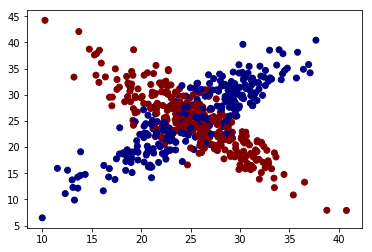

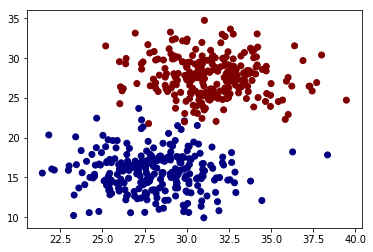

In [250]:
dataset_d = df_d.values
dataset_ind = df_ind.values

plt.scatter(dataset_d[:,0], dataset_d[:,1], c=dataset_d[:,-1], cmap='jet')
plt.show()

plt.scatter(dataset_ind[:,0], dataset_ind[:,1], c=dataset_ind[:,-1], cmap='jet')
plt.show()

Note that (like many things in nature) these datasets are **normally distributed**.

Let's create our NormalDestributedClass() class to aggregate all relevant parameters of the normal destribution:

In [251]:
class NormalDestributedClass():
    def __init__(self, dataset, class_value, get_instance_likelihood):
        self.class_value = class_value
        self.data_by_class = dataset[dataset[:,-1] == class_value][:,:-1]
        
        self.prior = self.data_by_class.shape[0] / dataset.shape[0]
        self.mean = np.mean(self.data_by_class, axis=0)
        self.std = np.std(self.data_by_class, axis=0)
        self.cov_mat = np.cov(*self.data_by_class.T)
        
        self.get_instance_likelihood = get_instance_likelihood
    
#     def get_instance_likelihood(self, x):
#         if self.normal_des_type == 'multi':
#             likelihood = multi_normal_pdf(x, self.mean, self.cov_mat)
#         else:
#             likelihood = normal_pdf(x, self.mean, self.std)
#         return likelihood

    def get_instance_posterior(self, x):
        return self.get_instance_likelihood(self, x) * self.prior # ignoring P(x)

Let's define the testing methods:

In [252]:
# creating train/test sets

def split_trainX_testY(dataset, train_ratio):
    train_ratio /= 100
    total_samples = dataset.shape[0]
    return dataset[:int(train_ratio * total_samples), :], dataset[int(train_ratio * total_samples):, :]

X_train_ind, X_test_ind = split_trainX_testY(dataset_ind, 70)
X_train_d, X_test_d = split_trainX_testY(dataset_d, 70)

In [253]:
# compute accuracy

def compute_accuracy(labeled_data, model, title):
    total = labeled_data.shape[0]
    correct_predictions = 0
    for x in labeled_data:
        if model.predict(x) == x[-1]:
            correct_predictions += 1
    print(title, correct_predictions / total)


In [254]:
# tests if prior probs sum to 1

def sum_priors(map_model):
    print('sum:', sum([cl.prior for cl in map_model.classes]))

## Naive Bayes

Naive Bayes assumes all features are **independent** (which means $cov(x_1,x_2,...,x_n) = 0$). That is:
### $$
P(x | C) = P(x_1, ... ,x_n | C) = \prod_{i=1}^n P(x_i | C)
$$
So the predition function assuming Naive Bayes is applied on our dataset is:
### $$
NB(x) = \underset{C_i}{argmax}\ P(x_1 | C_i) P(x_2 | C_i) P(C_i)
$$

To find the likelyhood probabilities $P(x | A), P(x | B)$ we use the normal destribution density function:
### $$
P(x | C) = \frac{1}{\sqrt{2\pi\sigma_c^2}} \cdot e^{\frac{(x - \mu_c)^2}{2\sigma_c^2}}
$$

In code:

In [255]:
def normal_pdf(x, mean, std):
    denominator = np.sqrt(2 * np.pi * std ** 2)
    power = - ((x - mean) ** 2) / (2 * std ** 2)
    return (1 / denominator) * np.e ** power

So in order to calculate the likelyhood of an instance $x$ belongs to a certain class:

In [256]:
def get_instance_likelihood_naive(self, x):
    return normal_pdf(x, self.mean, self.std).prod()

In [257]:
# creating models

MAP_model_ind = MAP_classifier(X_train_ind, NormalDestributedClass, get_instance_likelihood_naive)
MAP_model_d = MAP_classifier(X_train_d, NormalDestributedClass, get_instance_likelihood_naive)

### Testing our model:

In [258]:
sum_priors(MAP_model_ind)
sum_priors(MAP_model_d)

sum: 1.0
sum: 1.0


In [259]:
compute_accuracy(X_test_ind, MAP_model_ind, "Naive Bayes on independent-feature dataset:")
compute_accuracy(X_test_d, MAP_model_d, "Naive Bayes on dependent-feature dataset:")

Naive Bayes on independent-feature dataset: 1.0
Naive Bayes on dependent-feature dataset: 0.48


We can see that the naive assumption only effective when dealing with independent features (for example: number of badrooms in a house and size of yard

So, how do we improve our model for $dataset\_d$? Clearly the naive assumption shall not be applied.

## Full Bayes

considering $dataset\_d$.

We know that obviously $P(x_1, x_2 | C) \ne P(x_1 | C)\cdot P(x_2 | C)$.

In this case, since out datasets are normally destributed, consider the **multi-variate density function**:

### $$ f(x;\mu,\Sigma) = P(x | \mu_i,\Sigma_i) = P(x | C_i) = \frac{1}{(2\pi)^{\frac{n}{2}} det(\Sigma )^{\frac{1}{2}}} \cdot e ^{-\frac{1}{2}(x-\mu)^T \Sigma ^ {-1} (x - \mu) }$$

Where : 
* $n$ is the number of features (2 in our case)
* $\mu$ is the distribution mean vector. (length 2 in our case)
* $\Sigma$ is the distribution covarince matrix. (size 2x2 in our case)

Let $\Sigma$ be the covariance matrix defined as:

### $$
\Sigma=\left[\begin{array}{cc}
V\left(x_{1}\right) & cov\left(x_{1},x_{2}\right)\\
cov\left(x_{2},x_{1}\right) & V\left(x_{2}\right)
\end{array}\right]
$$

In code (using $np.cov()$):

In [260]:
def compute_cov_mat(dataset, title):
    class_A = dataset[dataset[:,-1] == 1]
    class_B = dataset[dataset[:,-1] == 0]
    print(title,'\t Class A:\n', np.cov(*class_A[:,:-1].T),'\n'*2,
          '\t Class B:\n', np.cov(*class_B[:,:-1].T), '\n')

compute_cov_mat(dataset_d, 'feature-DEPENDENT dataset:\n')
compute_cov_mat(dataset_ind, 'feature-INDEPENDENT dataset:\n')
    

feature-DEPENDENT dataset:
 	 Class A:
 [[ 22.43354273 -23.03161421]
 [-23.03161421  32.72945377]] 

 	 Class B:
 [[26.17559471 26.55390187]
 [26.55390187 36.11121458]] 

feature-INDEPENDENT dataset:
 	 Class A:
 [[ 5.75782146 -0.53307485]
 [-0.53307485  6.05314081]] 

 	 Class B:
 [[ 6.76896684 -0.30427782]
 [-0.30427782  6.49609002]] 



We can see that when features are dependent, convariance is larger, and much smaller when independet. **Makes sense!**

Let's implement the desity dunction $f$:

In [261]:
def multi_normal_pdf(x, mean, cov):
    """
    Calculate multi variante normal desnity function for a given x, mean and covarince matrix.
    """
    denominator = ((2 * np.pi) ** - (x.size / 2) * np.linalg.det(cov)) ** -.5
    power = -.5 * (x - mean).T @ np.linalg.inv(cov) @ (x - mean)
    multi_normal_value = denominator * np.e ** power
    return multi_normal_value

So in order to calculate the likelyhood of an instance $x$ belongs to a certain class:

In [271]:
def get_instance_likelihood_full(self, x):
    return multi_normal_pdf(x, self.mean, self.cov_mat).prod()

In [272]:
# creating models

full_MAP_model_ind = MAP_classifier(X_train_ind, NormalDestributedClass, get_instance_likelihood_full)
full_MAP_model_d = MAP_classifier(X_train_d, NormalDestributedClass, get_instance_likelihood_full)

In [273]:
sum_priors(MAP_model_ind)
sum_priors(MAP_model_d)

sum: 1.0
sum: 1.0


In [277]:
compute_accuracy(X_train_ind, full_MAP_model_ind, "Full Bayes on independent-feature dataset:")
compute_accuracy(X_test_d, full_MAP_model_d, "Full Bayes on dependent-feature dataset:")

Full Bayes on independent-feature dataset: 0.9914285714285714
Full Bayes on dependent-feature dataset: 0.8285714285714286
